In [138]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from models import functions

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [139]:
df = pd.read_csv('notebook/MGM_history.csv', index_col=0)

In [140]:
df.head()

,close,volume,vwap,changeOverTime,high,low,open
2020-05-21,15.99,31344500.0,16.02667,-0.00436,16.44,15.65,16.06
2020-05-20,16.50,37198300.0,16.26000,0.04364,16.58,15.70,15.81
2020-05-19,15.16,24387300.0,15.16333,-0.01173,15.69,14.64,15.34
2020-05-18,15.31,32223400.0,15.08667,0.03098,15.42,14.53,14.85
2020-05-15,13.85,25530400.0,13.70667,0.03281,14.07,13.20,13.41


In [141]:
TRAIN_SPLIT = int(len(df)*0.8)

In [142]:
TRAIN_SPLIT

1007

In [143]:
# constants 
EVALUATION_INTERVAL = 200
EPOCHS = 10

BATCH_SIZE = 10
BUFFER_SIZE = 10000

In [144]:
features_considered = ['close', 'high', 'low', 'open', 'vwap', 'changeOverTime']

close   high    low   open      vwap  changeOverTime
2020-05-21  15.99  16.44  15.65  16.06  16.02667        -0.00436
2020-05-20  16.50  16.58  15.70  15.81  16.26000         0.04364
2020-05-19  15.16  15.69  14.64  15.34  15.16333        -0.01173
2020-05-18  15.31  15.42  14.53  14.85  15.08667         0.03098
2020-05-15  13.85  14.07  13.20  13.41  13.70667         0.03281
...           ...    ...    ...    ...       ...             ...
2015-05-29  20.05  20.28  20.00  20.18  20.11000        -0.00644
2015-05-28  20.19  20.21  19.80  19.83  20.06667         0.01815
2015-05-27  19.91  19.96  19.74  19.89  19.87000         0.00101
2015-05-26  19.87  20.36  19.78  20.31  20.00333        -0.02166
2015-05-22  20.51  20.59  20.17  20.17  20.42333         0.01686

[1259 rows x 6 columns]


,close,high,low,open,vwap,changeOverTime
2020-05-21,15.99,16.44,15.65,16.06,16.02667,-0.00436
2020-05-20,16.50,16.58,15.70,15.81,16.26000,0.04364
2020-05-19,15.16,15.69,14.64,15.34,15.16333,-0.01173
2020-05-18,15.31,15.42,14.53,14.85,15.08667,0.03098
2020-05-15,13.85,14.07,13.20,13.41,13.70667,0.03281


2020-05-21    15.99
2020-05-20    16.50
2020-05-19    15.16
2020-05-18    15.31
2020-05-15    13.85
              ...  
2015-05-29    20.05
2015-05-28    20.19
2015-05-27    19.91
2015-05-26    19.87
2015-05-22    20.51
Name: close, Length: 1259, dtype: float64


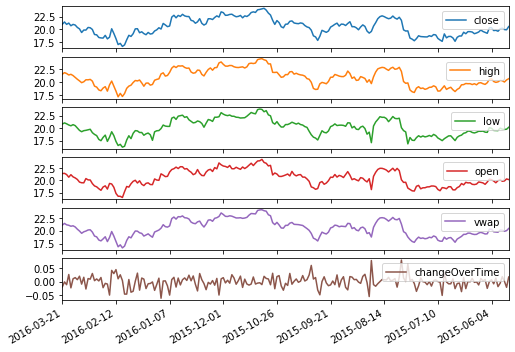

In [145]:
features = df[features_considered]
print(features)
features[1050:].plot(subplots=True)
display(features.head())
print(features.iloc[:, 0])

In [146]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [147]:
# dataset = (dataset-data_mean)/data_std

In [148]:
dataset[:, 0]

array([15.99, 16.5 , 15.16, ..., 19.91, 19.87, 20.51])

In [149]:
print(len(dataset))

1259


In [150]:
past_history = 50 # how many past days to consider
future_target = 5 # how many days to predict in the future 
STEP = 1

x_train_single, y_train_single = functions.multivariate_data(dataset, dataset[:, 0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)

x_val_single, y_val_single = functions.multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [151]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print ('\n Target price to predict : {}'.format(y_train_single[0].shape))

Single window of past history : (50, 6)

 Target price to predict : ()


In [152]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [153]:
train_data_single

<RepeatDataset shapes: ((None, 50, 6), (None,)), types: (tf.float64, tf.float64)>

In [154]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [155]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(10, 1)


In [156]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 29ms/step - loss: 23.0344 - val_loss: 11.2659
Epoch 2/10
200/200 [==============================] - 4s 20ms/step - loss: 17.3253 - val_loss: 6.2600
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 12.4185 - val_loss: 1.8354
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 7.6017 - val_loss: 3.4007
Epoch 5/10
200/200 [==============================] - 4s 20ms/step - loss: 3.9135 - val_loss: 6.5183
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 2.9662 - val_loss: 7.6775
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 2.9265 - val_loss: 6.5082
Epoch 8/10
200/200 [==============================] - 5s 23ms/step - loss: 2.5136 - val_loss: 9.8085
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 1.9747 - val_loss: 9.6709
Epoch 10/10
200/200 [=======================

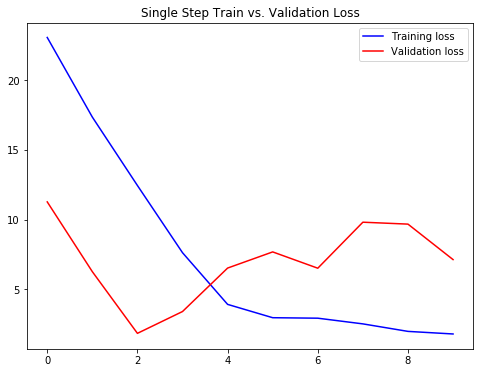

In [157]:
functions.plot_train_history(single_step_history, 'Single Step Train vs. Validation Loss')

In [158]:
print(val_data_single)

<RepeatDataset shapes: ((None, 50, 6), (None,)), types: (tf.float64, tf.float64)>


10
1


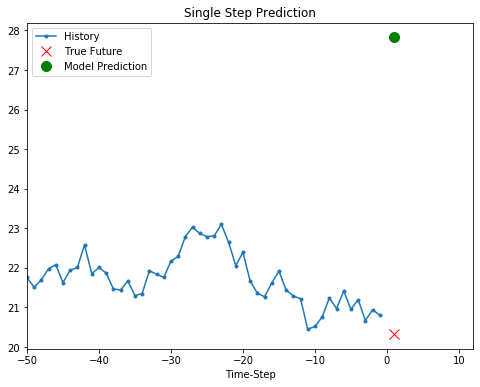

10
2


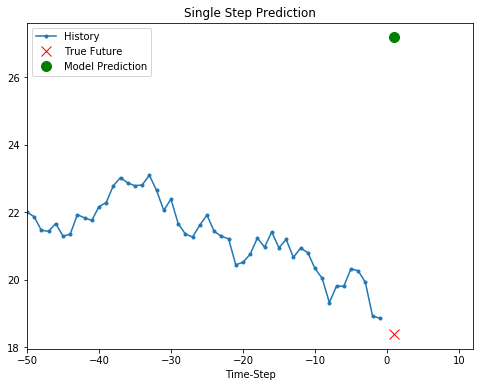

10
3


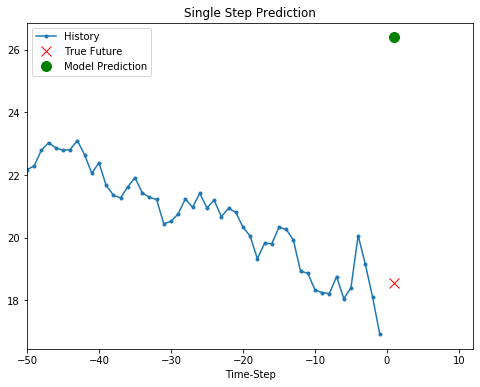

10
4


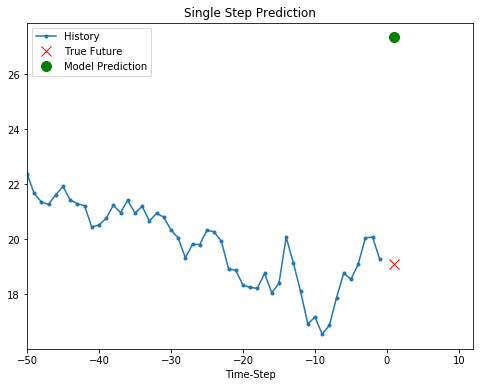

10
5


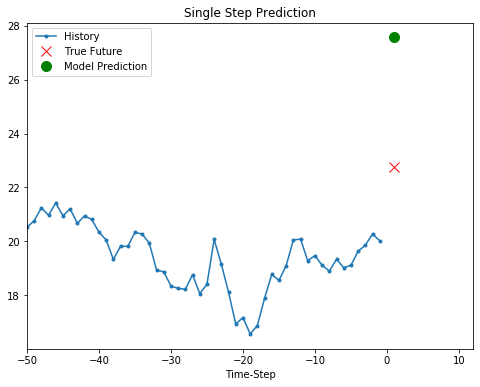

10
6


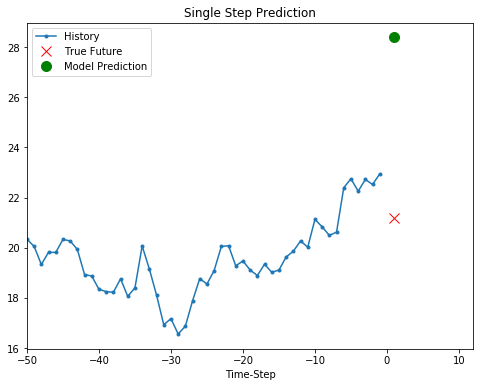

10
7


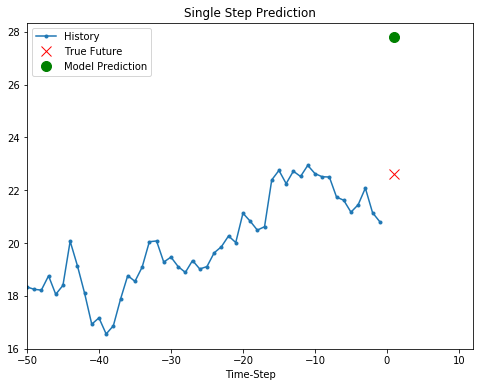

10
8


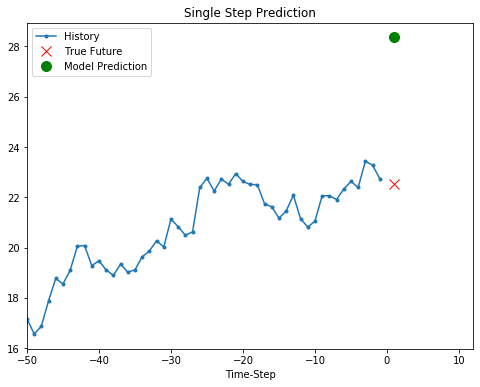

10
9


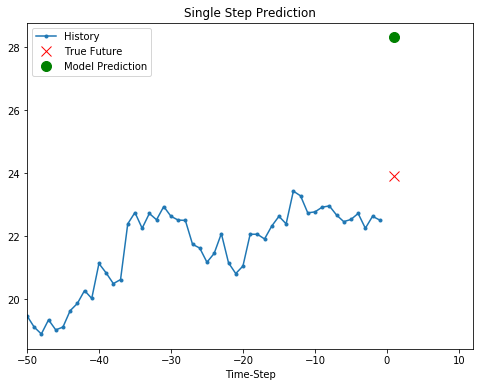

10
10


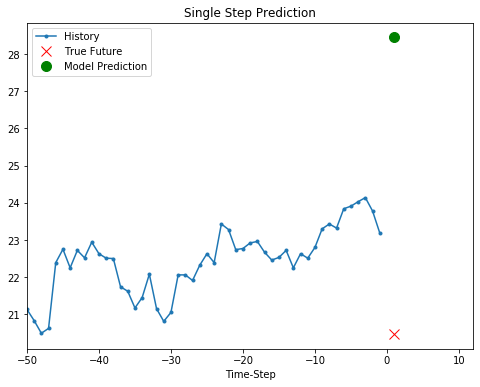

In [160]:
count = 0
for x, y in val_data_single:
    print(len(x))
    plot = functions.show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
    count = count + 1
    print (count)
    plot.show()